# Synthetic results analysis

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"]     = 150

## Utils

In [13]:
def chamfer(df, prefix, legend, threshold_bnds=(0.00, 0.3), color="gray"):
    import matplotlib.pyplot as plt
    
    pattern = re.compile(r"refined_chamfer_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    cd_t = []    
    t = []
    for th in thresholds:
        if float(th) < threshold_bnds[0] or float(th) > threshold_bnds[1]: continue
        cd = df[f"{prefix}_chamfer_{th}"].mean()
        cd_t.append(cd)
        t.append(float(th))
     
     
    plt.plot(t, cd_t, label=legend, color=color)
    plt.xlabel("Threshold [Prob]")
    plt.ylabel("d_chamfer [vox]")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    
    
def chamfer_adaptive(df, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = df["refined_chamfer_adaptive"].mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) [vox] {suffix}"
    )
    plt.legend(loc="right")
    plt.tight_layout()

def emd_adaptive(df, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = df["refined_emd_adaptive"].mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) [vox] {suffix}"
    )
    plt.legend(loc="right")
    plt.tight_layout()

def dice3d(df, prefix, legend, threshold_bnds=(0, 1), color="gray"):
    import matplotlib.pyplot as plt
    
    pattern = re.compile(r"refined_chamfer_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    cd_t = []    
    t = []
    for th in thresholds:
        if float(th) < threshold_bnds[0] or float(th) > threshold_bnds[1]: continue
        cd = df[f"{prefix}_dice3d_{th}"].mean()
        cd_t.append(cd)
        t.append(float(th))
     
     
    plt.plot(t, cd_t, label=legend, color=color)
    plt.xlabel("Threshold [Prob]")
    plt.ylabel("Dice3d [Frac]")
    plt.title(f"Dice3d")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()


def dice3d_adaptive(df, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = df["refined_dice3d_adaptive"].mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) {suffix}"
    )
    plt.legend(loc="right")


def metric_difference(df, metric_name, log=False, inverted=False, color="gray", legend=""):
    pattern = re.compile(r"refined_dice3d_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    d3d_t = []    
    t = []
    for th in thresholds:
        d3d = df[f"refined_{metric_name}_{th}"].mean()
        d3d_bp = df[f"backproj_{metric_name}_{th}"].mean()
        t.append(float(th))
        if inverted: d3d_t.append(d3d_bp - d3d)
        else: d3d_t.append(d3d - d3d_bp)

    import matplotlib.pyplot as plt

    plt.plot(t, d3d_t, color=color, label=legend)
    plt.ylabel("difference [Frac]")
    plt.xlabel("threshold [Prob]")
    if log: plt.yscale("log")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    
def metric_difference_adaptive(df, metric_name, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = (df[f"refined_{metric_name}_adaptive"] - df[f"backproj_{metric_name}_adaptive"]).mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) {suffix}"
    )
    plt.legend(loc="lower right")


def latex_make_table(h, v_ours, v_gan, caption="", label=""):
    table = r"\begin{table}\begin{center}\begin{tabular}{lc}" + "\n"
    table += r"\hline" + "\n"
    table += f"Model & {h} \\\\\n"
    table += r"\hline" + "\n"
    table += f"Ours & {v_ours:.2f} \\\\\n"
    table += f"Baseline (gan) & {v_gan:.2f} \\\\\n"
    table += r"\hline" + "\n"
    table += r"\end{tabular}\end{center}" + "\n"
    table += r"\caption{" + caption + r" \label{" + label + r"}}" + "\n"
    table += r"\end{table}" + "\n"
    return table


def mean_ci(series, n_boot=10000, confidence=0.95, seed=42):
    import numpy as np
    rng = np.random.default_rng(seed)
    data = series.dropna().values
    means = [np.mean(rng.choice(data, size=len(data), replace=True)) for _ in range(n_boot)]
    lower, upper = np.percentile(means, [(1 - confidence) / 2 * 100, (1 + confidence) / 2 * 100])
    return np.mean(data), lower, upper

def ci_pretty(df, col):
    mean, lo, hi = mean_ci(df[col])
    print(f"{mean:.2f} ({lo:.2f}-{hi:.2f})")

## Right

In [129]:
df_diffusion = pd.read_csv("../data/synthetic_diffusion_right.csv")
df_unet = pd.read_csv("../data/synthetic_unet_right.csv")

df_adaptive_diffusion = pd.read_csv("../data/synthetic_adaptive_diffusion_right.csv")
df_adaptive_unet = pd.read_csv("../data/synthetic_adaptive_unet_right.csv")

df_best_diffusion = pd.read_csv("../data/synthetic_both_right.csv")


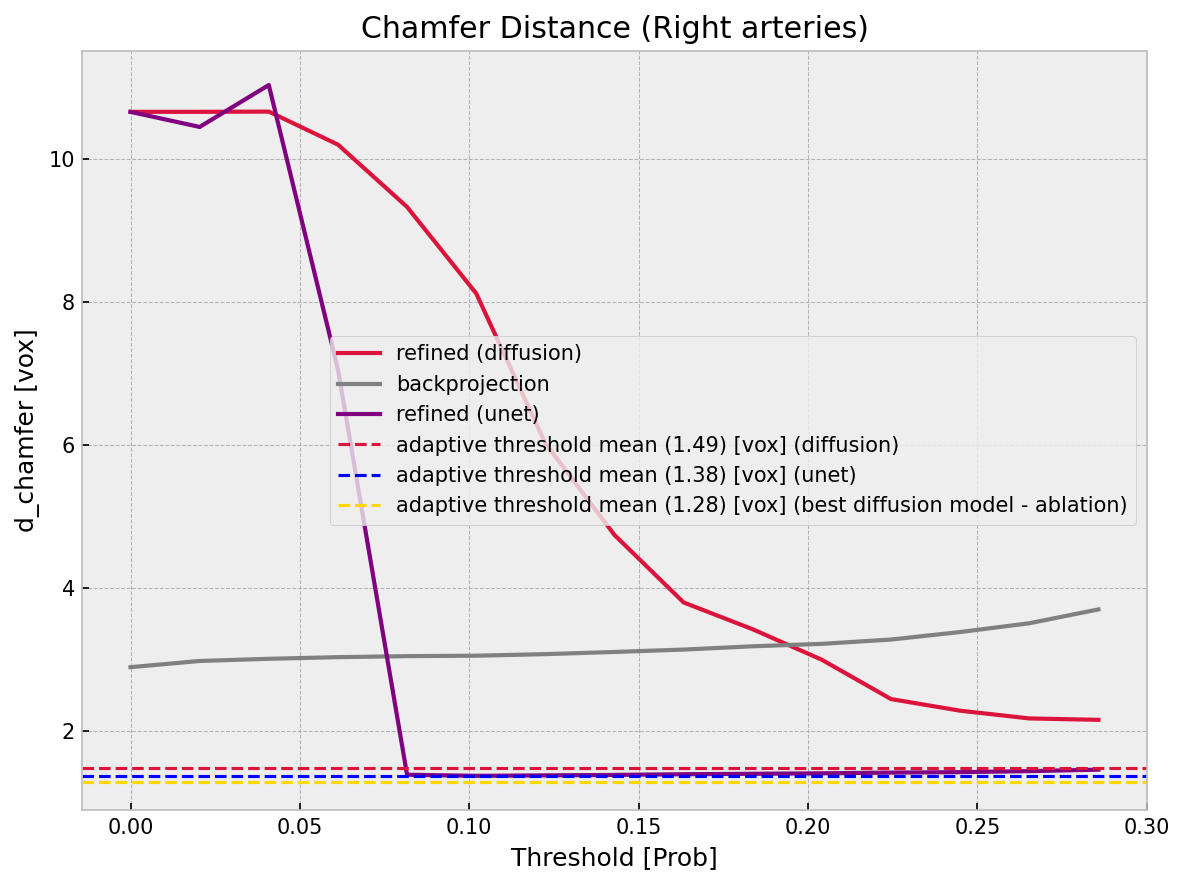

In [130]:
plt.title(f"Chamfer Distance (Right arteries)")
chamfer(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
chamfer(df_diffusion, prefix="backproj", legend="backprojection", color="gray")
chamfer(df_unet, prefix="refined", legend="refined (unet)", color="purple")
chamfer_adaptive(df_adaptive_diffusion, color="crimson")
chamfer_adaptive(df_adaptive_unet, color="blue", suffix="(unet)")
chamfer_adaptive(df_best_diffusion, color="gold", suffix="(best diffusion model - ablation)")


Text(0.5, 1.0, 'Dice3d (Right arteries)')

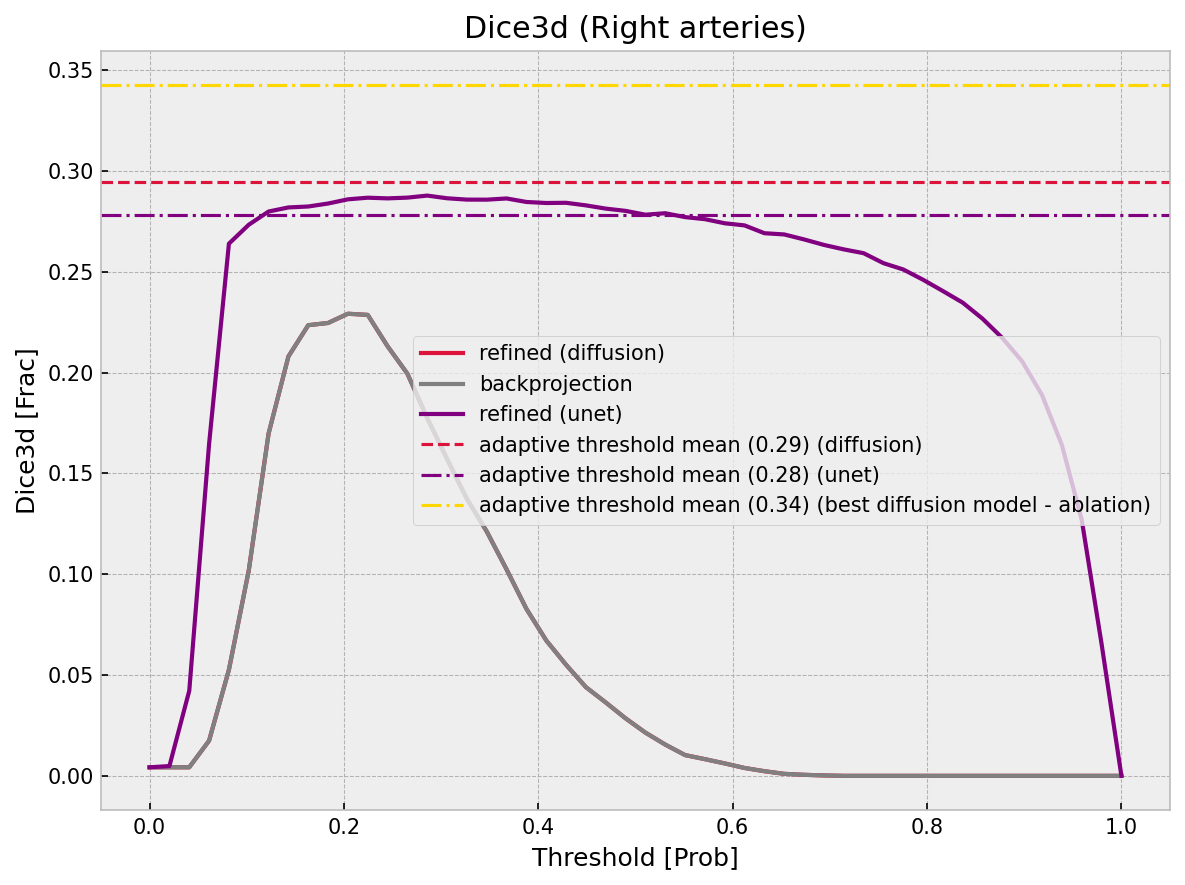

In [131]:
dice3d(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
dice3d(df_diffusion, prefix="backproj", legend="backprojection", color="gray")
dice3d(df_unet, prefix="refined", legend="refined (unet)", color="purple")
dice3d_adaptive(df_adaptive_diffusion, color="crimson")
dice3d_adaptive(df_adaptive_unet, color="purple", line="-.", suffix="(unet)")
dice3d_adaptive(df_best_diffusion, color="gold", line="-.", suffix="(best diffusion model - ablation)")
plt.title(f"Dice3d (Right arteries)")


In [110]:
ci_pretty(df_adaptive_diffusion, "refined_emd_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_diffusion, "PSNR")
ci_pretty(df_adaptive_diffusion, "elapsed")

ci_pretty(df_adaptive_diffusion, "chamfer_distance0")
ci_pretty(df_adaptive_diffusion, "chamfer_distance1")
ci_pretty(df_adaptive_diffusion, "dice2d0")
ci_pretty(df_adaptive_diffusion, "dice2d1")

ci_pretty(df_adaptive_diffusion, "interpret_frac")

6.75 (6.24-7.27)
1.49 (1.35-1.64)
0.29 (0.26-0.32)
0.56 (0.52-0.60)
0.76 (0.72-0.79)
27.79 (26.94-28.61)
3.08 (3.04-3.12)
10.42 (8.79-12.22)
6.47 (5.69-7.27)
0.40 (0.35-0.45)
0.55 (0.52-0.58)
0.11 (0.10-0.13)


In [111]:
ci_pretty(df_adaptive_unet, "refined_emd_adaptive")
ci_pretty(df_adaptive_unet, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_unet, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_unet, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_unet, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_unet, "PSNR")
ci_pretty(df_adaptive_unet, "elapsed")

ci_pretty(df_adaptive_unet, "chamfer_distance0")
ci_pretty(df_adaptive_unet, "chamfer_distance1")
ci_pretty(df_adaptive_unet, "dice2d0")
ci_pretty(df_adaptive_unet, "dice2d1")

ci_pretty(df_adaptive_unet, "interpret_frac")

6.18 (5.26-7.07)
1.38 (1.19-1.61)
0.28 (0.24-0.31)
0.49 (0.44-0.54)
0.68 (0.63-0.74)
34.10 (33.72-34.48)
0.02 (0.00-0.05)
8.74 (7.01-10.53)
6.43 (5.14-7.81)
0.46 (0.40-0.51)
0.57 (0.53-0.60)
0.24 (0.19-0.29)


In [132]:
ci_pretty(df_best_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_best_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_best_diffusion, "refined_Ot(1)_adaptive")
ci_pretty(df_best_diffusion, "refined_Ot(2)_adaptive")
ci_pretty(df_best_diffusion, "PSNR")
ci_pretty(df_best_diffusion, "elapsed")


ci_pretty(df_best_diffusion, "chamfer_distance0")
ci_pretty(df_best_diffusion, "chamfer_distance1")
ci_pretty(df_best_diffusion, "dice2d0")
ci_pretty(df_best_diffusion, "dice2d1")

ci_pretty(df_best_diffusion, "interpret_frac")

1.28 (1.16-1.42)
0.34 (0.31-0.38)
0.60 (0.56-0.64)
0.79 (0.75-0.82)
33.29 (32.74-33.83)
3.04 (3.00-3.08)
7.08 (6.05-8.17)
5.51 (4.57-6.52)
0.50 (0.46-0.55)
0.62 (0.59-0.65)
0.17 (0.15-0.19)


# Left

In [136]:
df_diffusion = pd.read_csv("../data/synthetic_diffusion_left.csv")
df_adaptive_diffusion = pd.read_csv("../data/synthetic_adaptive_diffusion_left.csv")
df_best_diffusion = pd.read_csv("../data/synthetic_no_projections_left.csv")
df_unet = pd.read_csv("../data/synthetic_unet_left.csv")
df_adaptive_unet = pd.read_csv("../data/synthetic_adaptive_unet_left.csv")
df_best_diffusion = pd.read_csv("../data/synthetic_no_projections_left.csv")


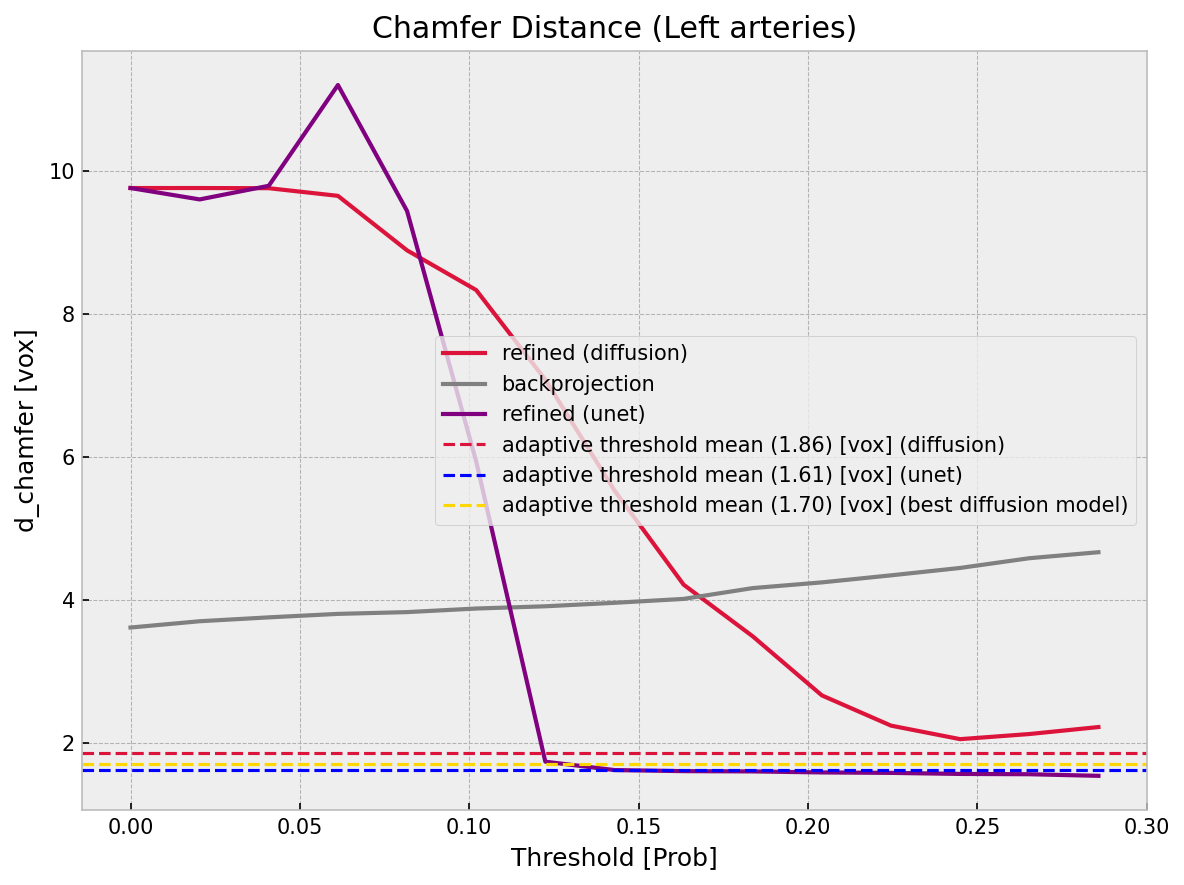

In [122]:
plt.title(f"Chamfer Distance (Left arteries)")
chamfer(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
chamfer(df_diffusion, prefix="backproj", legend="backprojection", color="gray")
chamfer(df_unet, prefix="refined", legend="refined (unet)", color="purple")
chamfer_adaptive(df_adaptive_diffusion, color="crimson")
chamfer_adaptive(df_adaptive_unet, color="blue", suffix="(unet)")
chamfer_adaptive(df_best_diffusion, color="gold", suffix="(best diffusion model)")


Text(0.5, 1.0, 'Dice3d (Left arteries)')

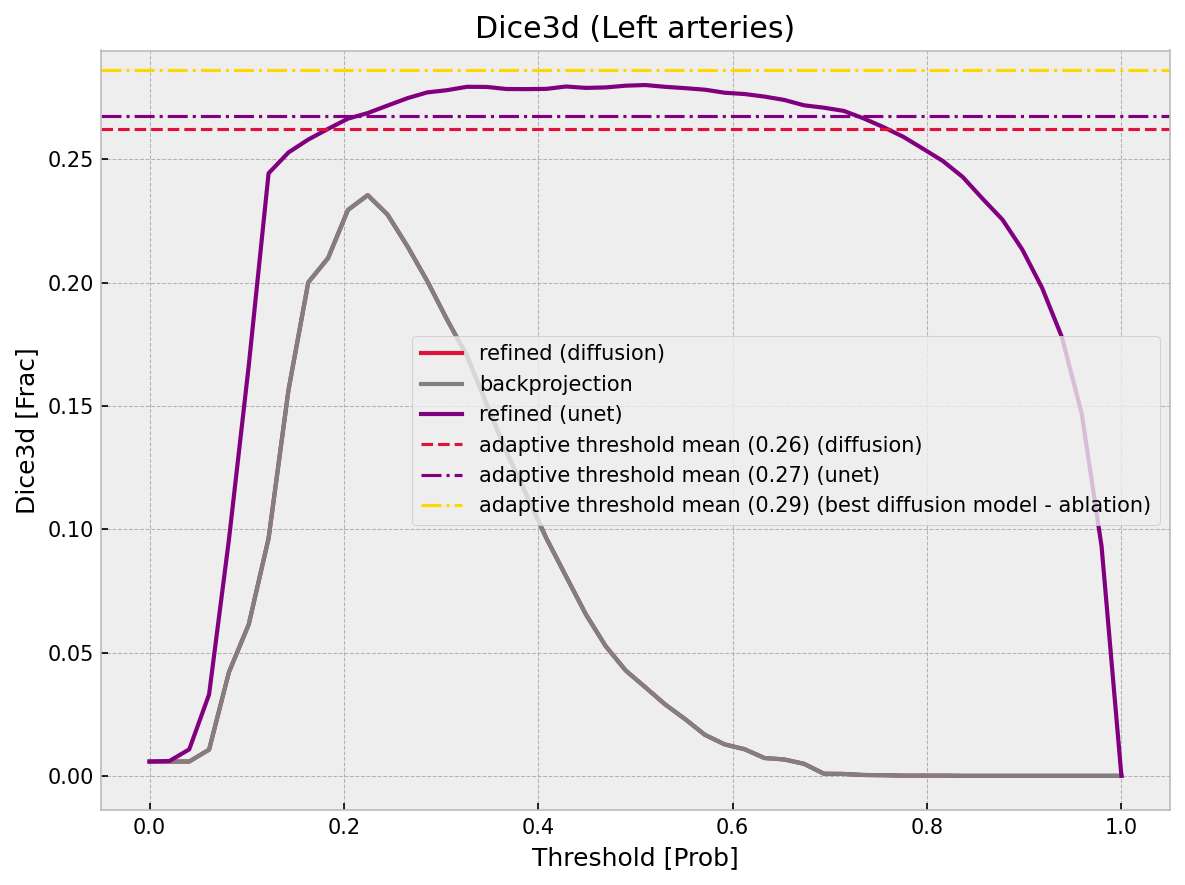

In [143]:
dice3d(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
dice3d(df_diffusion, prefix="backproj", legend="backprojection", color="gray")
dice3d(df_unet, prefix="refined", legend="refined (unet)", color="purple")
dice3d_adaptive(df_adaptive_diffusion, color="crimson")
dice3d_adaptive(df_adaptive_unet, color="purple", line="-.", suffix="(unet)")
dice3d_adaptive(df_best_diffusion, color="gold", line="-.", suffix="(best diffusion model - ablation)")
plt.title(f"Dice3d (Left arteries)")


In [137]:
ci_pretty(df_adaptive_diffusion, "refined_emd_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_diffusion, "PSNR")
ci_pretty(df_adaptive_diffusion, "elapsed")

ci_pretty(df_adaptive_diffusion, "chamfer_distance0")
ci_pretty(df_adaptive_diffusion, "chamfer_distance1")
ci_pretty(df_adaptive_diffusion, "dice2d0")
ci_pretty(df_adaptive_diffusion, "dice2d1")

ci_pretty(df_adaptive_diffusion, "interpret_frac")

8.77 (8.05-9.50)
1.86 (1.54-2.25)
0.26 (0.23-0.29)
0.51 (0.46-0.55)
0.71 (0.65-0.75)
27.60 (26.86-28.36)
3.03 (2.99-3.08)
8.32 (5.93-11.31)
10.48 (8.00-13.56)
0.60 (0.56-0.64)
0.48 (0.44-0.52)
0.23 (0.21-0.25)


In [138]:
ci_pretty(df_adaptive_unet, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_unet, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_unet, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_unet, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_unet, "PSNR")
ci_pretty(df_adaptive_unet, "elapsed")

ci_pretty(df_adaptive_unet, "chamfer_distance0")
ci_pretty(df_adaptive_unet, "chamfer_distance1")
ci_pretty(df_adaptive_unet, "dice2d0")
ci_pretty(df_adaptive_unet, "dice2d1")

ci_pretty(df_adaptive_unet, "interpret_frac")

1.61 (1.27-2.02)
0.27 (0.23-0.31)
0.47 (0.41-0.53)
0.66 (0.59-0.73)
31.44 (31.06-31.88)
0.02 (0.01-0.06)
7.24 (4.60-11.11)
9.72 (6.12-14.39)
0.60 (0.53-0.64)
0.52 (0.45-0.58)
0.43 (0.36-0.49)


In [139]:
ci_pretty(df_best_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_best_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_best_diffusion, "refined_Ot(1)_adaptive")
ci_pretty(df_best_diffusion, "refined_Ot(2)_adaptive")
ci_pretty(df_best_diffusion, "PSNR")
ci_pretty(df_best_diffusion, "elapsed")

ci_pretty(df_best_diffusion, "chamfer_distance0")
ci_pretty(df_best_diffusion, "chamfer_distance1")
ci_pretty(df_best_diffusion, "dice2d0")
ci_pretty(df_best_diffusion, "dice2d1")

ci_pretty(df_best_diffusion, "interpret_frac")

1.70 (1.41-2.07)
0.29 (0.26-0.31)
0.53 (0.49-0.57)
0.72 (0.67-0.76)
28.74 (28.03-29.41)
3.04 (3.00-3.08)
7.51 (4.93-10.82)
9.89 (7.18-13.24)
0.63 (0.59-0.66)
0.52 (0.48-0.56)
0.32 (0.29-0.35)
